In [1]:
import pandas as pd
import numpy as np

In [2]:
import numpy as np


In [3]:

import scipy.stats as sst


def get_edfs(x1,x2, sorter=None):
    if sorter is None:
        vals=np.concatenate([x1,x2])
        sorter=np.argsort(vals)
    edf1=np.concatenate([np.ones_like(x1)/x1.shape[0],np.zeros_like(x2)])[sorter]
    edf2=np.concatenate([np.zeros_like(x1), np.ones_like(x2)/x2.shape[0]])[sorter]
    return np.cumsum(edf1), np.cumsum(edf2)


In [4]:

import scipy.special as ssp

In [5]:

def logbeta(i,j):
    return ssp.loggamma(i) + ssp.loggamma(j)-ssp.loggamma(i+j)

def logbinom(i,j):
    
    return ssp.loggamma(i) + ssp.loggamma(j)-ssp.loggamma(i+j)

In [8]:

# def logbinom(i,j):
#     return ssp.loggamma(i+j+1) - ssp.loggamma(i+1)-ssp.loggamma(j+1)

In [9]:

import numpy as np
def loglik_edf(feature, target):
    s=np.argsort(feature)
    target_cl1_below=np.concatenate([[0],np.cumsum(target[s])])
    target_cl0_below=np.concatenate([[0],np.cumsum(1-target[s])])

    target_cl1_above=np.sum(target[s]) - target_cl1_below
    target_cl0_above=np.sum(1-target[s]) - target_cl0_below
    return target_cl1_below
    # target_cl0_above+target_cl0_below
    proba_below = (1+target_cl1_below)/ (target_cl0_below + target_cl1_below+2)
    proba_above = (1+target_cl1_above)/ (target_cl0_above + target_cl1_above+2)


    loglik = np.log(proba_below)* target_cl1_below + np.log(1-proba_below) * (target_cl0_below) +\
    np.log(proba_above)* target_cl1_above + np.log(1-proba_above) * (target_cl0_above)

    edf = np.cumsum(np.exp(loglik - np.max(loglik)))
    edf = edf /edf[-1]
    return edf,feature[s], np.argmax(loglik),np.max(loglik)



13.083024303278316

In [118]:

from collections import namedtuple

Splitpoint = namedtuple('Splitpoint',['stat', 'point','idxpoint','idx_feature','counts','total_stat'],
                       defaults=[0.,0,0,0,0,0])


def twosample_to_featuretarget(x1,x2):
    return np.concatenate([x1,x2]),np.concatenate([np.zeros_like(x1),np.ones_like(x2)])
    
def featuretarget_to_twosample(ft,tar):
    return ft[tar==0], ft[tar==1]

def rate_split(feature, target):
    s=np.argsort(feature)
    x1,x2=featuretarget_to_twosample(feature,target)
    target_cl1_below=np.concatenate([[0],np.cumsum(target[s])])
    target_cl0_below=np.concatenate([[0],np.cumsum(1-target[s])])

    target_cl1_above=np.sum(target[s]) - target_cl1_below
    target_cl0_above=np.sum(1-target[s]) - target_cl0_below
    proba_below = (1+target_cl1_below)/ (target_cl0_below + target_cl1_below+2)
    proba_above = (1+target_cl1_above)/ (target_cl0_above + target_cl1_above+2)


    loglik1 = np.log(proba_below)* target_cl1_below + np.log(1-proba_below) * (target_cl0_below) +\
        np.log(proba_above)* target_cl1_above + np.log(1-proba_above) * (target_cl0_above)

    ev=logbeta(target_cl0_below+1, target_cl1_below+1)+logbeta(target_cl0_above+1, target_cl1_above+1)
    evidence1=ssp.logsumexp(
    logbeta(target_cl0_below+1, target_cl1_below+1)+logbeta(target_cl0_above+1, target_cl1_above+1)
    )- np.log(target.shape[0])
    

    split_point=0
    evidence=-1e300
    if len(feature) > 0:
        split_point=feature[s][np.argmax(ev)]
        evidence=evidence1
    return loglik1,evidence,s, Splitpoint(point=split_point,
            counts=[int(np.sum(x1>=split_point)),int(np.sum(x2>=split_point)),len(x1),len(x2)])


def rate_cat_split(cl1bin0, cl0bin0,cl1bin1, cl0bin1):
    cl1=cl1bin0+cl1bin1
    cl0=cl0bin0+cl0bin1
    
    proba0=(cl1+1)/(cl1+cl0+2)
    evidence0=logbeta(cl1+1, cl0+1)
    loglik0=(np.log(proba0) * cl1 + np.log(1-proba0) * cl0)
    
    posterior0= loglik0- evidence0
    
    probab0=(cl1bin0+1)/(cl1bin0+cl0bin0+2)
    evidenceb0=logbeta(cl1bin0+1, cl0bin0+1)
    loglikb0=(np.log(probab0) * cl1bin0 + np.log(1-probab0) * cl0bin0)
    
    probab1=(cl1bin1+1)/(cl1bin1+cl0bin1+2)
    evidenceb1=logbeta(cl1bin1+1, cl0bin1+1)
    loglikb1=(np.log(probab1) * cl1bin1 + np.log(1-probab1) * cl0bin1)
    posterior1 = (loglikb1+loglikb0) - (evidenceb1+evidenceb0)
    
    return -evidence0+(evidenceb1+evidenceb0),  evidence0,(evidenceb1+evidenceb0)
    
    

def rate_all_splits(features, target):
    data=[]
    proba0=(np.sum(target)+1)/(target.shape[0]+2)
    evidence0=logbeta(np.sum(target)+1, np.sum(1-target)+1)
    loglik0=(np.log(proba0) * np.sum(target) + np.log(1-proba0) * np.sum(1-target))
    for i in range(features.shape[1]):
        loglik1,evidence1,s,split = rate_split(features[:,i], target)
        data.append(dict(i=i,loglik=loglik1, evidence=evidence1, split=split._replace(idx_feature=i,
                stat=evidence1-evidence0)))
#     logliks=[d['maxloglik'] for d in data]
    evidence = [d['evidence'] for d in data]
    maxevidence = np.max(evidence)
    arg = np.argmax(evidence)
    
    total_evidence = ssp.logsumexp(evidence)-np.log(features.shape[1])
    best_choice = data[arg]
    
    data= sorted(data,key=lambda x: x['evidence'])
    
    return total_evidence- evidence0, [d['split'] for d in data]

    
    
        

In [ ]:

## below some experiments at establishing distribution of evidence ration - seems 
## that adding log(sqrt(N*M/(N+M))) gives value that has fixed distribution

## this not used yet in a tree

In [354]:

for i in [10,20,30,50,60,70,80,90,100,120,140,160,200]:
    k1,k2=i,i
    def test2():
        x1=np.random.randint(0,2,k1)
        x2=np.random.randint(0,2,k2)
        return rate_cat_split(np.sum(x1),np.sum(1-x1),np.sum(x2),np.sum(1-x2))

    sample3=np.array([test2() for _ in range(200000)])
    print (i,"%.4f" % np.mean(sample3[:,0]+np.log(np.sqrt((k1*k2)*2/(k2+k1)))),
    "%.4f" %np.quantile(sample3[:,0]+np.log(np.sqrt((k1*k2)*2/(k2+k1))),0.95))

10 0.9288 2.1332
20 0.9986 2.3061
30 1.0218 2.6231
50 1.0459 2.5258
60 1.0499 2.5486
70 1.0507 2.5943
80 1.0540 2.3630
90 1.0543 2.4317
100 1.0574 2.5103
120 1.0596 2.4320
140 1.0614 2.3936
160 1.0648 2.5820
200 1.0653 2.5602


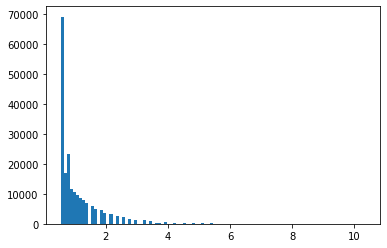

In [359]:
plt.hist(sample3[:,0]+np.log(np.sqrt((k1*k2)*2/(k2+k1))),bins=100);

0.009896824611116316

In [15]:
X1=np.random.randn(30000,3)-0.0
X2=np.random.randn(30000,3)+0.0
features=np.concatenate([X1,X2])#.reshape(-1,1)
target= np.concatenate([np.zeros_like(X1[:,0]),np.ones_like(X2[:,0])])

rate_all_splits(features,target)

(-3.5236660500595463,
 [Splitpoint(stat=-3.7666412197213504, point=-3.76625240735568, idxpoint=0, idx_feature=2, counts=[30000, 29991, 30000, 30000], total_stat=0),
  Splitpoint(stat=-3.7079234071061364, point=3.796696497620582, idxpoint=0, idx_feature=1, counts=[2, 0, 30000, 30000], total_stat=0),
  Splitpoint(stat=-3.198697379739315, point=2.9927841316439108, idxpoint=0, idx_feature=0, counts=[59, 28, 30000, 30000], total_stat=0)])

41178.217796328536

In [22]:

import collections
INode=namedtuple('Node', ['feature','threshold','lc','rc','counts'],defaults=[-1,0,None,None,None])

def serializer(obj):
    if isinstance(obj, list):
        return obj
    if isinstance(obj,float) or isinstance(obj,np.float64):
        return round(obj,3)
    elif hasattr(obj,'__dict__'):
        return vars(obj)
    else:
        str(obj)


SplitProposal=namedtuple('SplitProposal', ['node','fidx','split','side'])
feature_use_per_path=5
class Node(object):
    def __init__(self, feature=-1, threshold=0,lc=None, rc=None,counts=None,options=None, 
                 pval_threshold=0.01,
                feature_use_per_path=3
                ):
        self.feature=feature
        self.threshold=threshold
        self.lc=lc 
        self.rc=rc
        self.counts=counts
        self.options = options
        self.pval_threshold=pval_threshold
        self.feature_use_per_path=feature_use_per_path
    @staticmethod
    def initialize_node(X,y, feature_use_per_path=3, pval_threshold=1):

        evidence, splits=rate_all_splits(X,y)
        split=splits[-1]
        return Node(split.idx_feature, split.point,counts=split.counts,feature_use_per_path=feature_use_per_path, pval_threshold=pval_threshold)
    def __repr__(self):
        import json
        return json.dumps(self.__dict__, default=serializer)
    def to_json(self):
        import json
        return json.dumps(self.__dict__, default=serializer)
    
    def options_to_consider(self, X: np.ndarray, y: np.ndarray, pruned_features=None):
        if pruned_features==None:
            pruned_features=[]
        pruned_features = pruned_features+ [self.feature]
        c=dict(collections.Counter(pruned_features))
        feature = X[:,self.feature]
        f = feature > self.threshold
        total_splits=[]
        changes_done=False
        if self.lc is None and np.sum(~f)>2:
            evidence, splits=rate_all_splits(X[~f], y[~f])
            splits = [s for s in splits if s.idx_feature not in c or c[s.idx_feature] < self.feature_use_per_path]
            if evidence > self.pval_threshold and len(splits)>0:
                split=splits[-1]
                self.lc = Node(split.idx_feature, split.point,counts=split.counts,feature_use_per_path=feature_use_per_path, pval_threshold=self.pval_threshold)
                changes_done = True

        else:
            if np.sum(~f)>2:
                changes_done = changes_done or self.lc.options_to_consider(X[~f],y[~f],pruned_features )
        if self.rc is None and np.sum(f)>2:
            
            evidence, splits=rate_all_splits(X[f], y[f])
            splits = [s for s in splits if s.idx_feature not in c or c[s.idx_feature] < self.feature_use_per_path]
            if evidence > self.pval_threshold and len(splits)>0:
                split=splits[-1]
                self.rc = Node(split.idx_feature, split.point,counts=split.counts,feature_use_per_path=feature_use_per_path, pval_threshold=self.pval_threshold)
                changes_done = True
        else:
            
            if np.sum(f)>2:
                changes_done = changes_done or self.rc.options_to_consider(X[f],y[f],pruned_features )
        return changes_done
            
    def iterate_fit(self,X,y):
        return self.options_to_consider(X,y)
    def predict(self, features):
        feature = features[:,self.feature]
        c= self.counts
        proba_right = (1+c[1])/(2+c[0]+c[1])
        proba_left = (1+c[3]-c[1])/(2+c[3]-c[1]+c[2]-c[0])
        f = feature > self.threshold
        result = np.zeros(f.shape[0])
        if self.rc is None:
            result[f] = proba_right
        else:
            result[f]=self.rc.predict(features[f])
            
        if self.lc is None:
            result[~f] = proba_left
        else:
            result[~f]=self.lc.predict(features[~f])
        return result
     
class KSModel(object):
    def __init__(self, feature_use_per_path=3, pval_threshold=0.01):
        self.n=None
        self.pval_threshold=pval_threshold
        self.feature_use_per_path=feature_use_per_path
    
    def fit(self,X,y):
        n=Node.initialize_node(X,y, feature_use_per_path=self.feature_use_per_path,pval_threshold=self.pval_threshold)
        while n.iterate_fit(X,y):
            
            pass
        self.n = n
    def predict(self,X):
        return self.n.predict(X)
        

In [24]:

from sklearn.metrics import roc_auc_score

from sklearn.tree import DecisionTreeClassifier



0.7857142857142857 0.7350970017636684


In [366]:

def test_dataset(df, f,preproc=lambda x:x):
    specs = [dict(max_depth=3),dict(max_depth=5),dict(max_depth=6), dict(max_depth=8),dict(min_samples_leaf=10),
            dict(max_depth=5, criterion='entropy'),dict(min_samples_leaf=50),dict(min_weight_fraction_leaf=0.01),dict()
            ]
    specs = [dict(max_depth=3),dict(max_depth=5),dict(max_depth=6), dict(max_depth=8),dict(min_samples_leaf=10),
            dict(max_depth=5, criterion='entropy'),dict(min_samples_leaf=50),dict(min_weight_fraction_leaf=0.01),dict(),
             dict(min_samples_leaf=5),dict(min_samples_leaf=20),dict(min_samples_leaf=10,criterion='entropy')
            ]
    results = []
    for i in range(100):
        df2=df.sample(frac=1,replace=False)
        df2=preproc(df2)
    #     df2[f]=  (df2[f]=='g')*1
        split = int(df2.shape[0]*0.8)
        train=df2.iloc[0:split]
        test=df2.iloc[split:]
        for s in specs:
            dec=DecisionTreeClassifier( **s)
            dec.fit(train.iloc[:,0:f].values, train.iloc[:,f].values)
            p=dec.predict_proba(test.iloc[:,0:f].values)[:,1]
            x1=(roc_auc_score(test.iloc[:,f].values,p))
            t1= np.mean(test.iloc[:,f].values==((p>0.5)*1))
            results.append((str(s),x1,t1))

        # dec=xgboost.XGBRFClassifier()
        # dec.fit(train.iloc[:,0:f].values, train.iloc[:,f].values)
        # p=dec.predict_proba(test.iloc[:,0:f].values)[:,1]
        # x3=(roc_auc_score(test.iloc[:,f].values,p))


        dec=KSModel(pval_threshold=-0.5)
        dec.fit(train.iloc[:,0:f].values, train.iloc[:,f].values)
        p=dec.predict(test.iloc[:,0:f].values)
        x2=(roc_auc_score(test.iloc[:,f].values,p))
        t1= np.mean(test.iloc[:,f].values==((p>0.5)*1))
        results.append(("bayes-0.5",x2,t1))

        dec=KSModel(pval_threshold=0)
        dec.fit(train.iloc[:,0:f].values, train.iloc[:,f].values)
        p=dec.predict(test.iloc[:,0:f].values)
        x2=(roc_auc_score(test.iloc[:,f].values,p))
        t1= np.mean(test.iloc[:,f].values==((p>0.5)*1))
        results.append(("bayes-0",x2,t1))

        dec=KSModel(pval_threshold=0.5)
        dec.fit(train.iloc[:,0:f].values, train.iloc[:,f].values)
        p=dec.predict(test.iloc[:,0:f].values)
        x2=(roc_auc_score(test.iloc[:,f].values,p))
        t1= np.mean(test.iloc[:,f].values==((p>0.5)*1))
        results.append(("bayes+0.5",x2,t1))
        
    s=pd.Series([r[1] for r in results],[r[0]for  r in results])
    print("ROC")
    print(s.groupby(s.index).mean())
    
    print("accuracy")
    s=pd.Series([r[2] for r in results],[r[0]for  r in results])
    print(s.groupby(s.index).mean())

In [ ]:

def preproc_haberman(df2):
    df2[3] = (df2[3]==2)*1
    return df2

def preproc_iono(df2):
    f=34
    df2[f]=  (df2[f]=='g')*1
    return df2
def preproc_sonar(df2):
    f=60
    df2[f]=  (df2[f]=='M')*1
    return df2
np.random.seed(0)
print("HABERMAN")
test_dataset(pd.read_csv("/home/krystian/dane/data/haberman.data",header=None),3, preproc_haberman)
print("DIABETES")
test_dataset(pd.read_csv("/home/krystian/dane/data/pima-indians-diabetes.csv",header=None),8)
print("SONAR")
test_dataset(pd.read_csv("/home/krystian/dane/data/sonar.all-data",header=None),60,preproc_sonar)
print("BANKNOTE")
test_dataset(pd.read_csv("/home/krystian/dane/data/data_banknote_authentication.txt",header=None),4)

print("IONOSPHERE")
test_dataset(pd.read_csv("/home/krystian/dane/data/ionosphere.data",header=None),34
             ,preproc_iono)

HABERMAN
ROC
bayes+0.5                                           0.632007
bayes-0                                             0.633217
bayes-0.5                                           0.630940
{'max_depth': 3}                                    0.629607
{'max_depth': 5, 'criterion': 'entropy'}            0.617487
{'max_depth': 5}                                    0.609307
{'max_depth': 6}                                    0.608853
{'max_depth': 8}                                    0.576767
{'min_samples_leaf': 10, 'criterion': 'entropy'}    0.650541
{'min_samples_leaf': 10}                            0.651819
{'min_samples_leaf': 20}                            0.657042
{'min_samples_leaf': 50}                            0.659467
{'min_samples_leaf': 5}                             0.619498
{'min_weight_fraction_leaf': 0.01}                  0.601996
{}                                                  0.554989
dtype: float64
accuracy
bayes+0.5                                       